In [2]:
# !pip install pystan
# !pip install fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from chart_studio import plotly 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [30]:
cdc_data = pd.read_csv('CDC_dataset.csv')

In [31]:
cdc_data.describe()

,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death
count,4.116000e+04,2.199100e+04,21919.000000,41160.000000,37159.000000,41160.000000,21771.000000,21771.000000,41160.000000,37098.000000
mean,3.334831e+05,3.577318e+05,45340.923582,1190.070505,182.406039,6178.508285,6902.206513,703.874007,18.815403,1.819209
std,5.997560e+05,5.650308e+05,69517.962414,2544.563086,520.709600,10332.127070,9309.179176,1094.737914,45.622450,27.823309
min,0.000000e+00,0.000000e+00,0.000000,-10199.000000,-10733.000000,0.000000,0.000000,0.000000,-352.000000,-2594.000000
25%,5.450000e+03,3.349200e+04,12.000000,28.000000,0.000000,116.000000,747.000000,0.000000,0.000000,0.000000
50%,1.028975e+05,1.538920e+05,8195.000000,351.000000,4.000000,1865.000000,3460.000000,208.000000,4.000000,0.000000
75%,4.329145e+05,4.996240e+05,63843.500000,1267.000000,145.000000,7819.250000,9513.500000,901.000000,18.000000,1.000000
max,5.113467e+06,4.851429e+06,381613.000000,61016.000000,16591.000000,74221.000000,71408.000000,5208.000000,1178.000000,2919.000000


In [32]:
cdc_data

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,04/01/2021,CA,3570660,3570660.0,0.0,2234,0.0,58090,58090.0,0.0,154,0.0,04/03/2021 12:00:00 AM,Agree,Agree
1,05/31/2021,CA,3685032,3685032.0,0.0,644,0.0,62011,62011.0,0.0,5,0.0,06/02/2021 12:00:00 AM,Agree,Agree
2,02/06/2020,NE,0,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
3,07/30/2020,ME,3910,3497.0,413.0,22,2.0,123,122.0,1.0,2,0.0,07/31/2020 02:35:06 PM,Agree,Agree
4,02/02/2021,MS,280182,176228.0,103954.0,1059,559.0,6730,4739.0,1991.0,13,7.0,02/04/2021 12:00:00 AM,Agree,Agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41155,07/19/2020,NJ,178541,NaN,NaN,-10,21.0,15706,13732.0,1974.0,34,27.0,07/19/2020 12:00:00 AM,Not agree,Agree
41156,08/13/2021,FSM,7,7.0,0.0,0,0.0,0,0.0,0.0,0,0.0,08/14/2021 02:46:52 PM,Agree,Agree
41157,12/15/2020,DC,25339,NaN,NaN,301,0.0,720,NaN,NaN,4,0.0,12/16/2020 02:28:57 PM,NaN,NaN
41158,03/26/2020,SC,474,474.0,0.0,83,0.0,5,NaN,NaN,1,0.0,03/26/2020 12:00:00 AM,Agree,Not agree


In [33]:
#Dropping columns which are not needed and renaming
cdc_data.drop(columns = ['tot_cases','tot_death','prob_cases','pnew_case','prob_death','pnew_death','consent_cases','consent_deaths','created_at'], inplace= True) 
cdc_data.rename(columns = {'submission_date':'Date','state':'State','conf_cases':'Total_cases_confirm','new_case':'daily_new_cases','conf_death':'Total_deaths_confirm','new_death':'daily_new_deaths'},inplace = True)
cdc_data['Date'] = pd.to_datetime(cdc_data['Date'])

The dataset contains state wise data for each date, thus combining state wise data to get number of overall cases in the USA.

In [34]:
US_data = cdc_data.groupby('Date',as_index = True).sum()
US_data

,Total_cases_confirm,daily_new_cases,Total_deaths_confirm,daily_new_deaths
Date,,,,
2020-01-22,0.0,0,0.0,0
2020-01-23,0.0,1,0.0,0
2020-01-24,0.0,1,0.0,0
2020-01-25,0.0,0,0.0,0
2020-01-26,0.0,1,0.0,0
...,...,...,...,...
2021-12-03,27304316.0,149321,379988.0,1416
2021-12-04,27332431.0,49887,380168.0,487
2021-12-05,27357938.0,43452,380202.0,182


Text(0.5, 1.0, 'Cumulative Covid-19 Case counts')

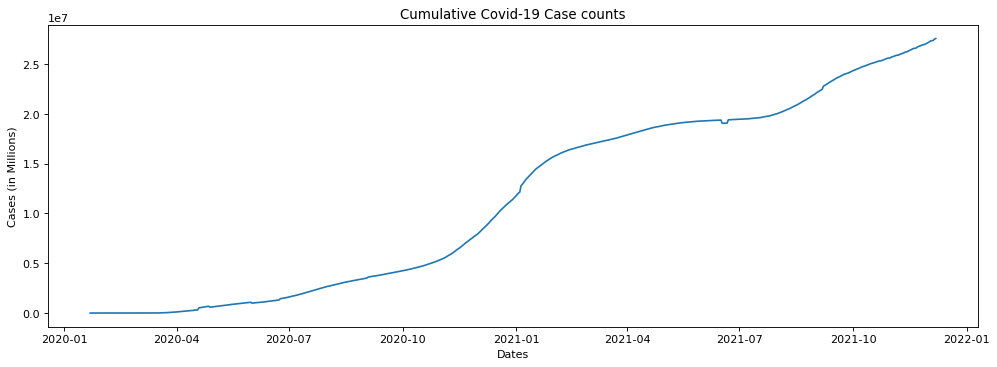

In [35]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['Total_cases_confirm'])
plt.ylabel('Cases (in Millions)')
plt.xlabel('Dates')
plt.title('Cumulative Covid-19 Case counts')

As expected the total confirmed cases increase from Jan 1, 2020 to Jan 1, 2022.

Text(0.5, 1.0, 'Daily Covid-19 Cases')

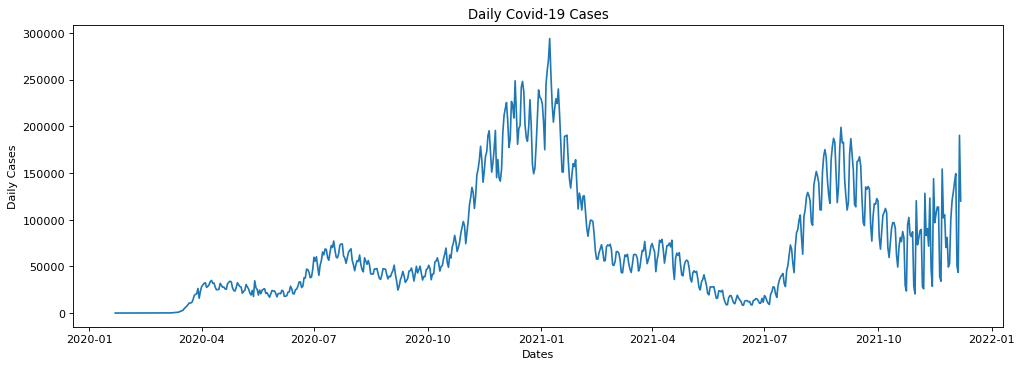

In [36]:
figure(figsize=(15, 5), dpi=80)
plt.plot(US_data['daily_new_cases'])
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.title('Daily Covid-19 Cases')

## TO DO: Compare with twitter

Due to the inaccuracies in daily cases reporting, we can consider taking a moving average to smoothen the curve, which can then be used for forecasting.

In [38]:
#7 day moving average
US_data['daily_deaths_sma7'] = US_data['daily_new_deaths'].rolling(window=7).mean()
US_data['daily_cases_sma7'] = US_data['daily_new_cases'].rolling(window=7).mean()

In [39]:
US_data

,Total_cases_confirm,daily_new_cases,Total_deaths_confirm,daily_new_deaths,daily_deaths_sma7,daily_cases_sma7
Date,,,,,,
2020-01-22,0.0,0,0.0,0,NaN,NaN
2020-01-23,0.0,1,0.0,0,NaN,NaN
2020-01-24,0.0,1,0.0,0,NaN,NaN
2020-01-25,0.0,0,0.0,0,NaN,NaN
2020-01-26,0.0,1,0.0,0,NaN,NaN
...,...,...,...,...,...,...
2021-12-03,27304316.0,149321,379988.0,1416,1083.142857,106085.571429
2021-12-04,27332431.0,49887,380168.0,487,1129.000000,106166.857143
2021-12-05,27357938.0,43452,380202.0,182,1133.000000,104758.428571


#### Forecasting using Time Series Analysis 

In [43]:
# split training set and test set 
train=US_data.iloc[:int(US_data.shape[0]*0.80)]
test=US_data.iloc[int(US_data.shape[0]*0.20):]
pred=test.copy()

In [50]:
train = train.dropna()

#### 1.) SARIMA ( The data is seasonal and hence using  Seasonal ARIMA)

In [59]:
model_sarima= auto_arima(train["daily_cases_sma7"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                         suppress_warnings=True,stepwise=False,seasonal=True)
model_sarima.fit(train["daily_cases_sma7"])

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9968.504, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=9944.845, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=9945.487, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=9942.652, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=9937.925, Time=0.18 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=9939.717, Time=0.29 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=9944.007, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=9939.888, Time=0.29 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=9940.129, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=9641.384, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=9643.375, Time=0.27 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=9643.666, Time=0.53 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=9643.373, Time=0.26 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=9632.500, Time=0.98 sec
 ARIMA(0,1,1)(2

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [60]:
prediction_sarima=model_sarima.predict(len(test))
pred["SARIMA Model Prediction"]=prediction_sarima


In [61]:
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(test["daily_cases_sma7"],prediction_sarima)))

Root Mean Square Error for SARIMA Model:  205114.25975495437


In [62]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train["daily_cases_sma7"],mode='lines+markers',name="Train Data for Daily New Cases"))
fig.add_trace(go.Scatter(x=test.index, y=test["daily_cases_sma7"],mode='lines+markers',name="Test Data for Daily New Cases",))
fig.add_trace(go.Scatter(x=test.index, y=pred["SARIMA Model Prediction"],mode='lines+markers',name="Prediction for Daily New Cases",))
fig.update_layout(title="SARIMA Prediction for Daily New Cases",xaxis_title="Date",yaxis_title="Daily New Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## TO DO :create stationary data